# Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from RegscorePy import aic
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [2]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

train_data  = pd.read_csv('data/transformed/DADO_TREINO_UBE_48_12_univariate.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
test_data = pd.read_csv('data/transformed/DADO_TESTE_UBE_48_12_univariate.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)

data = pd.concat([train_data, test_data], axis=0)

data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]

data = data['1/1/2015 12:00:00 AM':]

data

,value,date
index,,
2015-01-01,481.0,2015-01-01
2015-01-02,481.0,2015-01-02
2015-01-03,473.0,2015-01-03
2015-01-04,472.0,2015-01-04
2015-01-05,461.0,2015-01-05
...,...,...
2019-12-17,281.0,2019-12-17
2019-12-18,299.0,2019-12-18
2019-12-19,312.0,2019-12-19


# 2. ARIMA

## 2.1 Tratando os dados internos

In [3]:
split_date = '1/1/2019 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]

raw_test = test.copy()
raw_train = train.copy()

train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)

raw_series = series.copy()
series

index
2015-01-01    481.0
2015-01-02    481.0
2015-01-03    473.0
2015-01-04    472.0
2015-01-05    461.0
              ...  
2019-12-17    281.0
2019-12-18    299.0
2019-12-19    312.0
2019-12-20    311.0
2019-12-21    295.0
Name: value, Length: 1817, dtype: float64

## 2.2 Métodos para treinamento

In [4]:
# Mostrar previsão de acordo com os dados originais
def plot_forecasts(series, forecasts, test):
    plt.plot(series) # blue

    # Colocando no gráfico as previsões com a cor vermelha
    for i in range(len(forecasts)):
        # Inicio e fim dos dos deslocamentos por x
        off_s = len(series) - len(test) + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]

        # Valores dos multiplos passos de previsão
        yaxis = [series[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')

    # Gráfico
    plt.show()

# Salvar predições, excedentes e erros
def save_results_file(test, forecasts, n_steps):
    predictions = {}
    expected = {}
    erros = {}
    for i in range(n_steps):
        # Pegando os valores de multiplos passos de previsão
        ypred_ts = [forecast[i] for forecast in forecasts]
        # Salvando previsão
        predictions['t+' + str(i+1)] = ypred_ts
        ytrue_ts = test[i:len(ypred_ts)+i]
        ytrue_ts_lst = [i for i in ytrue_ts]

        # Salvando excedente
        expected['t+' + str(i+1)] = ytrue_ts_lst

        # Calculando e salvando erro
        erro = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        erros['t+' + str(i+1)] = erro

    with open('data/retrain/daily_flow_predictions_arima.txt', 'w') as output:
        for k, v in predictions.items():
            output.write(str(k)+'\n')
            output.write(str(v)+'\n')

    with open('data/retrain/daily_flow_expected_arima.txt', 'w') as output:
        for k, v in expected.items():
            output.write(str(k)+'\n')
            output.write(str(v)+'\n')

    with open('data/retrain/daily_flow_errors_arima.txt', 'w') as output:
        for k, v in erros.items():
            output.write(str(k)+'\n')
            output.write(str(v)+'\n')

# Avaliação de erro do ARIMA
def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    sum_aic = 0
    
    for i in range(n_steps):
        ypred_ts = [forecast[i] for forecast in forecasts]
        ytrue_ts = test[i:len(ypred_ts)+i]
        # Calculando os erros
        mape = mean_absolute_percentage_error(ytrue_ts, ypred_ts)*100
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        aic_error = aic.aic(ytrue_ts, ypred_ts, 3)

        sum_rmse += rmse
        sum_mape += mape
        sum_aic += aic_error
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape} | AIC: {aic_error}")

    # média dos erros
    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")
    print(f"Média do AIC: {sum_aic/n_steps}")

# Treinamento de previsão por ARIMA por multiplos passos
def arima_forecast(train, config, n_steps):
    p, d, q = config
    # Definindo e moldando o modelo
    model = ARIMA(train, order=(p,d,q), trend=None, trend_offset=1)
    model_fit = model.fit()

    # Fazendo previsão com multiplos passos
    yhat = model_fit.predict(len(train), len(train)+n_steps-1)
    yhat_list = [value for value in yhat]

    return yhat_list

## 2.3 Treinamento e resultado

t+1 RMSE: 17.99117139908514 | MAPE: 2.9040278980494483 | AIC: 2023.137049501288
t+2 RMSE: 36.66434393121843 | MAPE: 5.662143644987919 | AIC: 2520.0596999955865
t+3 RMSE: 54.824299131520206 | MAPE: 8.22322033823041 | AIC: 2800.88519031744
t+4 RMSE: 70.87139107953335 | MAPE: 10.333902827403733 | AIC: 2980.0850551846243
t+5 RMSE: 84.81498252460067 | MAPE: 12.293577534043742 | AIC: 3105.4496011185893
t+6 RMSE: 96.4349824223057 | MAPE: 14.018270684481383 | AIC: 3195.0705787427128
t+7 RMSE: 105.9328302921024 | MAPE: 15.635106788433987 | AIC: 3260.638041301735
Média do RMSE: 66.79057154005227
Média do MAPE: 9.867178530804376
Média do AIC: 2840.7607451659965


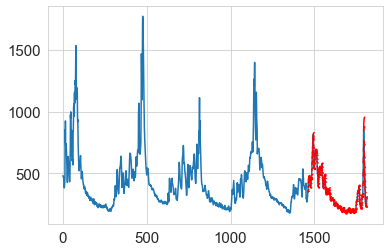

In [5]:
test = test.values
series = series.values
train = [x for x in train]

n_steps = 7

# configurações da previsão ARIMA
p_param = 1
d_param = 1
q_param = 1  # 1, 0
config = [p_param, d_param, q_param]

# lista para armazenar os paços de predição e a quantidade de predições a frente
forecasts = list()
n_forecasts = len(test) - n_steps + 1

for i in range(n_forecasts):
    try:
        yhat = arima_forecast(train, config, n_steps)
    except:
        continue
    # adicionando valor de predição a lista
    forecasts.append(yhat)
    # Adicionando valor de previsão pelo treino para o proximo loop
    obs = test[i]
    train.append(obs)

# Salvar predições, excedentes e erros
save_results_file(test, forecasts, n_steps)
# Avaliação da previsão
evaluate_forecasts(test, forecasts, n_steps)
# Mostrar previsão
plot_forecasts(series, forecasts, test)

In [6]:
_test = test.copy()
_forecasts = forecasts.copy()
_series = series.copy()

In [7]:
def plot(series, forecasts, test):
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(series.index, series, 'C1', label='values', color='blue')
    ax.plot(forecasts.index, forecasts, 'C2', label='forecasts', color='red')
    ax.legend()

def Extract(lst):
    return list(list(zip(*lst))[0])

def avg(lst):
    return list(map(np.mean, lst))

forecast_series = pd.Series(Extract(forecasts), index=raw_test.index[:len(forecasts)])

In [8]:
raw_test = raw_test.set_index('date')

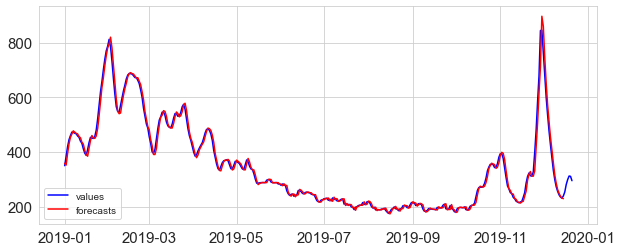

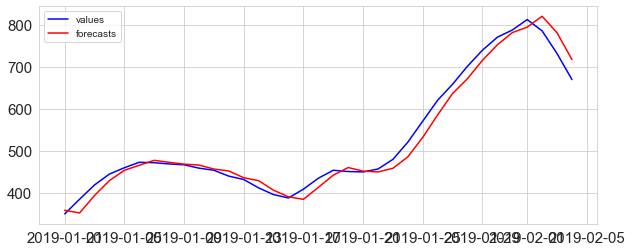

In [9]:
limit = int(len(test)*0.1)
plot(raw_test, forecast_series, test)
plot(raw_test[:limit], forecast_series[:limit], test)